In [1]:
import os
import json
import pandas as pd
import numpy as np

from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/voter-behavior-prediction-LLM/

/content/drive/MyDrive/voter-behavior-prediction-LLM


In [4]:
# Constants
SAMPLE_SIZE = 90
RANDOM_STATE = 42
ENV_FILE_PATH = '.env'

In [5]:
def load_env_variables(file_path):
    """Load key-value pairs from a .env file and set them as environment variables."""
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith('#'):
                key, value = line.split('=', 1)
                os.environ[key] = value

load_env_variables(ENV_FILE_PATH)

In [6]:
# Function to load city codes from a file into a dictionary
def load_city_codes(file_path):
    city_codes = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            code, name = line.strip().split(':')
            city_codes[int(code)] = name
    return city_codes

# Load city codes from the file
file_path = 'city_codes.txt'
city_mapping = load_city_codes(file_path)

In [7]:
# Load survey data
df_survey_data = pd.read_excel('survey.xlsx')
print("Survey data loaded successfully.")

Survey data loaded successfully.


In [8]:
df_survey_data

,id,username,location_x,total_tweet_num,ide_turkish_nationalism_x,ide_conservatism_x,ide_islamism_x,ide_liberalism_x,ide_kemalism_x,ide_social_democracy_x,...,seçimler_ve_oy_survey,göç_survey,din_survey,çevre_ve_ekoloji_survey,kürt_meselesi_survey,belediye_hizmetleri_survey,hayvan_hakları_survey,yolsuzluk_survey,konut_problemi_survey,deprem_survey
0,33589312,otisabi,48.0,3163,13,1,2,13,9,13,...,1,0,0,0,0,0,0,1,0,0
1,122750163,drcihanyilmaz,NaN,3142,292,28,15,14,104,39,...,1,1,0,0,0,0,0,1,0,1
2,22439422,arda,NaN,3095,4,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,786668601583337472,fridakahlo,NaN,3243,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,293125949,dilekozcengiz,1.0,3119,46,3,4,63,29,33,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,1477912991744118784,talatcemalenver,NaN,4,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
927,536372566,metehankosar,NaN,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
928,814847028375257088,alikara1905,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
929,1363845612,tcsecil,NaN,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
# Preprocess the data
# 1) Convert float to integer for 'Age' column
df_survey_data['Age_EN'] = df_survey_data['Age_survey'].fillna(0).astype(int)

# 2) Map education levels to desired strings
education_mapping = {
    'Üniversite mezunu': 'university graduate',
    'Yüksek lisans/Doktora': "master's degree/PhD holder",
    'Lise mezunu': "high-school graduate",
    'İlköğretim/Ortaokul mezunu': "secondary school graduate",
    'İlkokul mezunu': "primary school graduate",
    'Diplomasız okur': "literate but nongraduate",
    np.nan: ""
}
df_survey_data['Eğitim_EN'] = df_survey_data['Eğitim'].map(education_mapping)

# 3) Map ethnicity to desired strings
ethnicity_mapping = {
    'Türk': 'Turkish',
    'Kürt': 'Kurdish',
    'Türk,Kürt': 'Turkish and Kurdish',
    'Türk,Zaza': 'Turkish and Zaza',
    'Türk,Diğer': 'partly Turkish',
    'Arap': 'Arab',
    'Diğer': "",
    np.nan: ""
}
df_survey_data['Etnisite_EN'] = df_survey_data['Etnisite'].map(ethnicity_mapping)

# 4) Map city codes to city names
df_survey_data['Şehir_EN'] = df_survey_data['Şehir'].map(city_mapping)

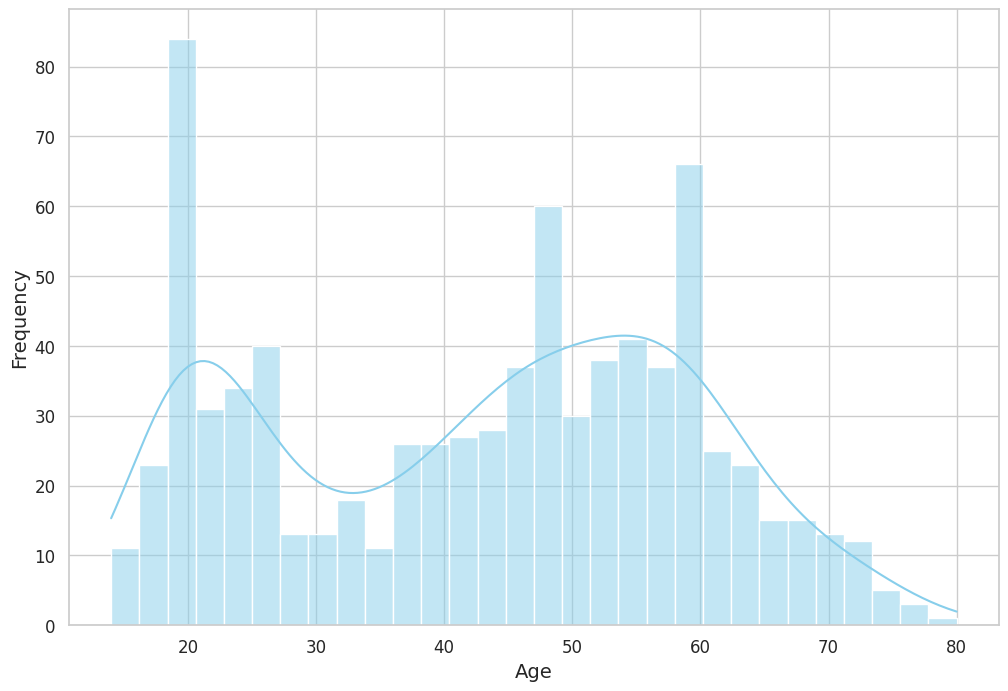

In [21]:
# Set style for plots
sns.set(style="whitegrid")

# Filter out ages less than or equal to 10 and greater than 80
df_filtered = df_survey_data[(df_survey_data['Age_EN'] > 10) & (df_survey_data['Age_EN'] <= 80)]

# Age distribution with more details on x-axis
plt.figure(figsize=(12, 8))
sns.histplot(df_filtered['Age_EN'], bins=30, kde=True, color='skyblue')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

<ipython-input-28-e64167e080b7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered[df_filtered['Eğitim_EN'].isin(top_5_education)],


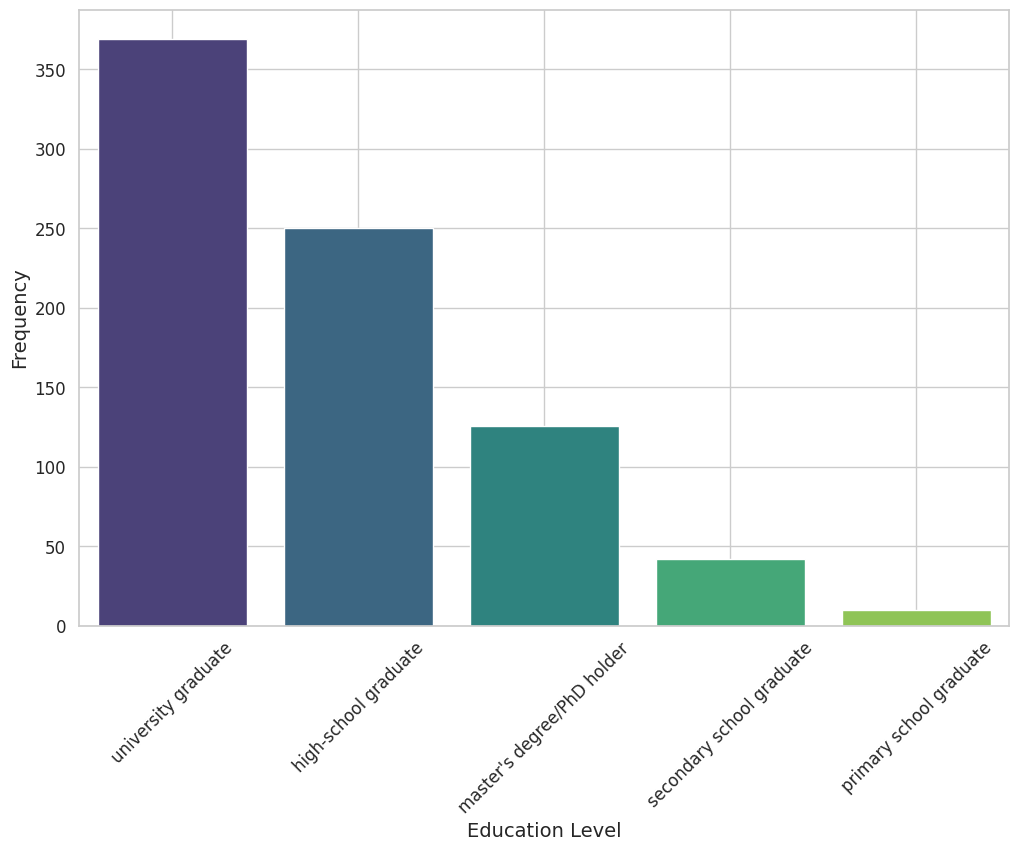

In [28]:
# Education level distribution (top 5 categories)
plt.figure(figsize=(12, 8))
top_5_education = df_filtered['Eğitim_EN'].value_counts().nlargest(5).index
sns.countplot(data=df_filtered[df_filtered['Eğitim_EN'].isin(top_5_education)],
              x='Eğitim_EN', palette='viridis',
              order=df_filtered['Eğitim_EN'].value_counts().nlargest(5).index)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

<ipython-input-23-3d93611f2c7c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='Etnisite_EN', palette='muted', order=df_filtered['Etnisite_EN'].value_counts().index)


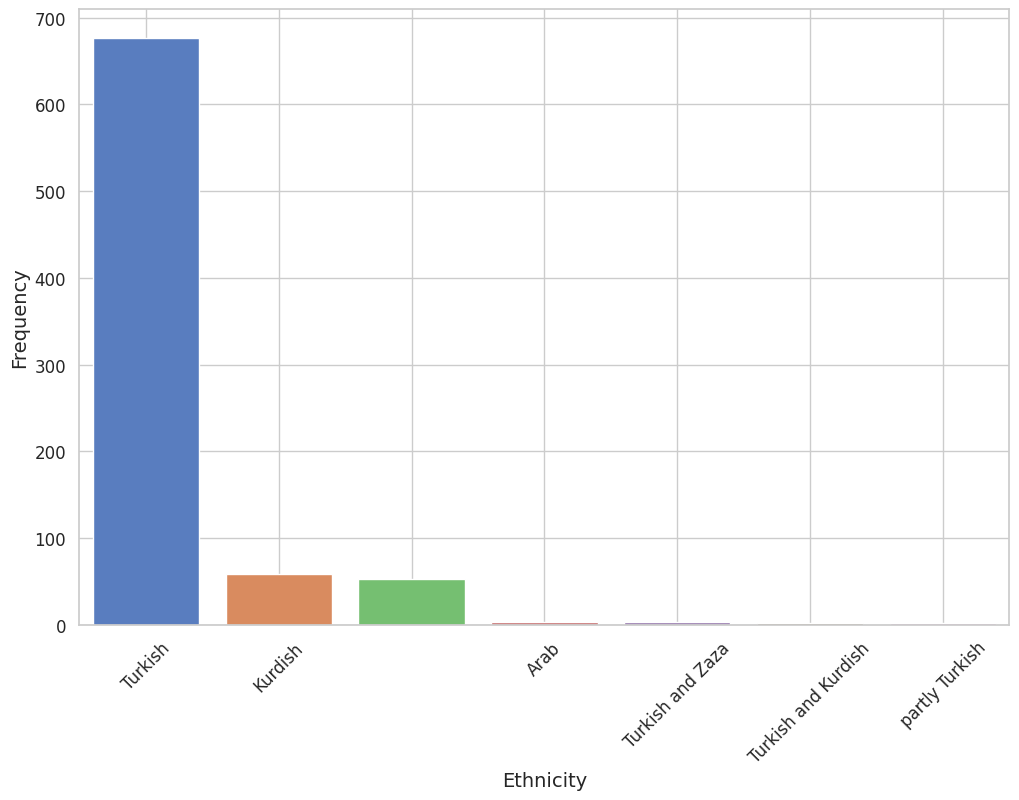

In [23]:
# Ethnicity distribution
plt.figure(figsize=(12, 8))
sns.countplot(data=df_filtered, x='Etnisite_EN', palette='muted', order=df_filtered['Etnisite_EN'].value_counts().index)
plt.xlabel('Ethnicity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

<ipython-input-24-9e852a297146>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='Şehir_EN', palette='cubehelix', order=df_filtered['Şehir_EN'].value_counts().index)


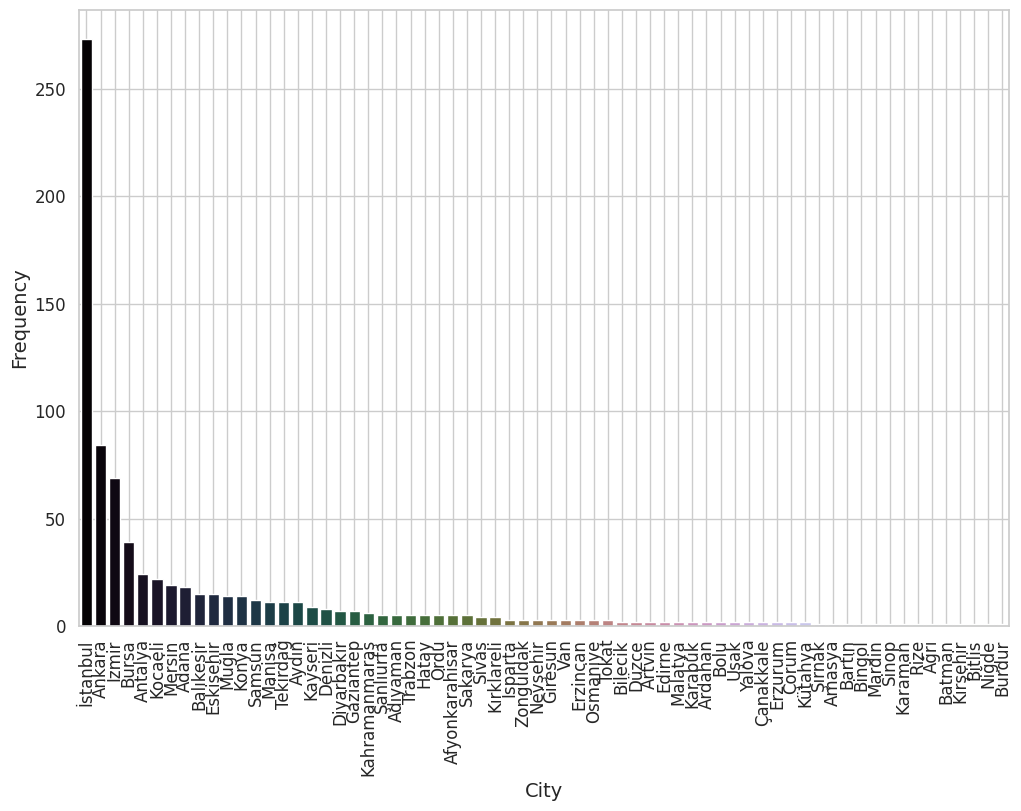

In [24]:
# City distribution
plt.figure(figsize=(12, 8))
sns.countplot(data=df_filtered, x='Şehir_EN', palette='cubehelix', order=df_filtered['Şehir_EN'].value_counts().index)
plt.xlabel('City', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

<ipython-input-25-eba7ed9ee772>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='gender_survey', palette='pastel', order=df_filtered['gender_survey'].value_counts().index)


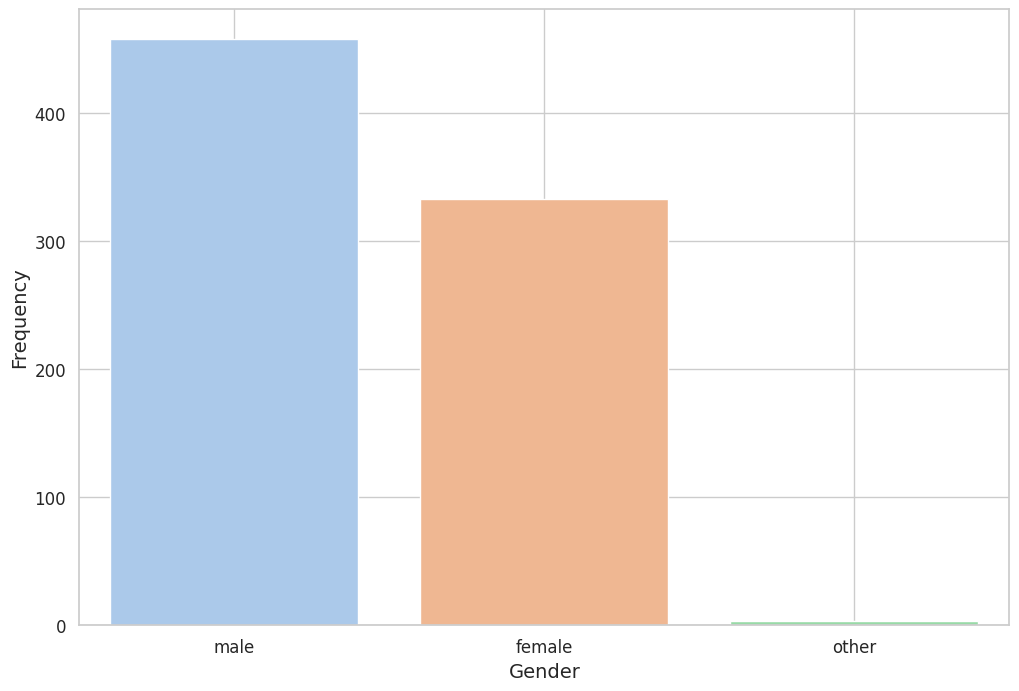

In [25]:
# Gender distribution
plt.figure(figsize=(12, 8))
sns.countplot(data=df_filtered, x='gender_survey', palette='pastel', order=df_filtered['gender_survey'].value_counts().index)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [12]:
# Display the first few rows of the survey data
df_survey_data[['username', 'Age_EN', 'Eğitim_EN', 'Etnisite_EN', 'Şehir_EN']].head()

,username,Age_EN,Eğitim_EN,Etnisite_EN,Şehir_EN
0,otisabi,59,university graduate,Turkish,Muğla
1,drcihanyilmaz,37,master's degree/PhD holder,Turkish,Manisa
2,arda,0,high-school graduate,Turkish,Çanakkale
3,fridakahlo,33,master's degree/PhD holder,Turkish,Ankara
4,dilekozcengiz,62,master's degree/PhD holder,Turkish,Adana
